# Tutorial for params_MOT

This package fits various parameters to images of molecules or atoms trapped in a magneto-optical trap (MOT).

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import seaborn as sns
import pandas as pd
import os

import math
import emcee

from params_MOT.io_package import get_data_file_path, load_data
from params_MOT.model import *
from params_MOT import MOT_image, Image_with_CCD_readout_charge, MOT_bare_model
import params_MOT as pm

from scipy.optimize import curve_fit

### Set parameters

To select a good number of "burn-in" steps set the suppressMessages parameter to True, look at the plotted traces of the walkers, and choose a step number after whihc the walkers are settled around a certain value.

In [2]:
#mc_params=(walkers, steps, burn_in_steps)
mc_params=(150, 1000, 500)

#initial_guess = [center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, readout_charge]
initial_guess = [25, 25, 100, 10, 10, 100, 20, 60]


### Run Model on Data and Show Results

The MCMC is contained in the function find_params_MOT in model.py. This function runs MCMC using the pm.sampler function, which calls upon the emcee package to compute marginal posteriors for the model parameters. There are 8 parameters to be marginalized over, which is encompassed in the variable theta in our package. theta is an array consisting of the following parameters:
(center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g)
The first 5 parameters give the 2D Gaussian for the MOT. background_offset is self-explanator. sigma_m is the uncertainty in the model, and sigma_m is the uncertainty from the scattered light background. When calling upon the find_params_MOT function, we have to specify an 8-tuple consisting of the initial guesses for theta, and also the duple mc_params = (nwalkers, nsteps) which controls the parameters of the MCMC.
From there one only needs to specify the filename of the data (which is presumed to be in the root folder of params_MOT, and the function will automatically run the MCMC and conclude the best fit parameters from the 50th percentile of the final state of the walkers.

#### Note on data file title format:
The data is stored in .csv files, using the following title convention (this is important because information is stored in the title, too): <br><br>
(time in ms)\_(series number)_(fraction of maximum laser power)power.csv
<br><br>
For example, the title '3_1_16power.csv' (used in the example below) means that the picture of the MOT was taken 3 ms after realising it from the trap, that the picture is part of the 1st series, and that the laser power used is $\frac{max\_power}{16}  = \frac{60}{16} \mathrm{mW}$. Not respecting the convention should rise an error pointing this out.
<br><br>
The directory in which the data is stored is given by the data_dir parameter. Nominally, we store the data in the GitHub/params_MOT/data folder.

Loading data...
The life time of and the laser power used on the MOT are 3 ms and 1/32 (fractional units out of the max power, which is 60mW per beam)
Data loaded. Running emcee sampler...
Emcee finished. Generating plots...
       sigma_x   sigma_y
0.16  7.582324  5.325485
0.50  7.754146  5.461427
0.84  7.932390  5.597782


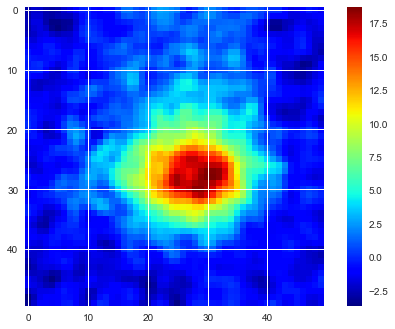

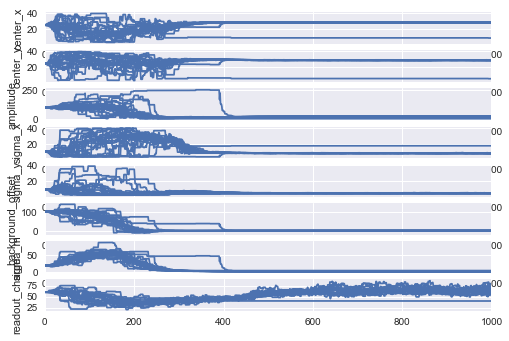

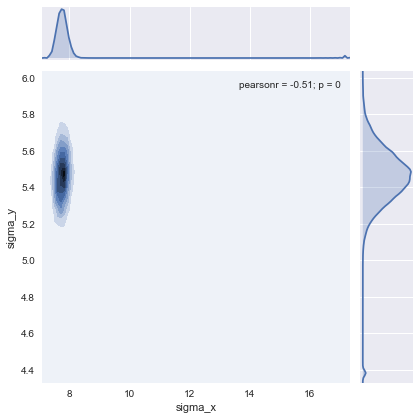

In [3]:
a = find_params_MOT('3_1_32power.csv', data_dir = 'data', image_size = 50, mc_params = mc_params, initial_guess = initial_guess, suppressMessages = False)

## Get the temperature

To get the temperature from the MOT size (i.e., from the standard deviations $\sigma_\mathrm{x}$ and $\sigma_\mathrm{y}$) we use the following formula: $$\sigma^2 = \sigma^2_{\mathrm{0}} + K_\mathrm{B} T \tau^2 /m,$$ where $\sigma$ stands for either $\sigma_{\mathrm{x}}$ or $\sigma_{\mathrm{y}}$, $\tau$ is the time, $T$ is temperature, $K_\mathrm{B}$ the Boltzmann constant, and $m$ the mass (= 59 amu = 9.80e-26 kg). 

The first step is to run the sampler on a list of data files. Belowe we get a list of all the .csv files in the folder given by the data_path string. The printed data_files array has the list of these files, which should ideally be part of the same series, with the same used power, and different times (['0.5_1_16power.csv', '2_1_16power.csv', '3_1_16power.csv', '4_1_16power.csv'] is a good example). You can change the array to drop/add files before calling the function to do the fitting to the data.

In [4]:
# Get the data files 
#(NOTE: this works if you have a folder called "data" one step up from the main repo folder; the data folder is not uploaded on GitHub)
data_path = 'data'
data_files = [f for f in os.listdir(data_path) if (os.path.isfile(os.path.join(data_path, f)) and f.split('.')[-1] == 'csv')]
separated_data_files = pm.separate_files_power(data_files)
print(separated_data_files)

[['0.5_1_8power.csv', '2_1_8power.csv', '3_1_8power.csv', '4_1_8power.csv'], ['0.5_1_16power.csv', '2_1_16power.csv', '3_1_16power.csv', '4_1_16power.csv'], ['0.5_1_32power.csv', '2_1_32power.csv', '3_1_32power.csv', '4_1_32power.csv'], ['0.5_1_64power.csv', '2_1_64power.csv', '3_1_64power.csv', '4_1_64power.csv']]


In [5]:
# Run sampler on all data files
q = find_params_MOTs(separated_data_files[1], 'data', 50, mc_params, initial_guess, suppressMessages = True)

Call function to infer the temeprature for the MOT, corresponding to each direction (for one number use formula $T = T_{\mathrm{x}}^{2/3} \times T_{\mathrm{y}}^{1/3}$).

NOTE: 
   - The true image size is 20 mm x 20 mm, so account for that too.
   - Time is in ms.
   - The power is given as the fraction of the max_power (which is 60 mW). 

     time    power   sigma_x  sigma_sigma_x   sigma_y  sigma_sigma_y  \
0  0.0005  0.00375  0.001935   1.931215e-05  0.001753   3.012639e-05   
1  0.0020  0.00375  0.002003   3.575790e-07  0.001955   8.668543e-07   
2  0.0030  0.00375  0.002113   1.202747e-07  0.002246   3.197853e-06   
3  0.0040  0.00375  0.002452   3.339086e-06  0.002335   2.990165e-07   

   sigma_x_squared  sigma_sigma_x_squared  sigma_y_squared  \
0         0.000004           3.729593e-10         0.000003   
1         0.000004           1.278628e-13         0.000004   
2         0.000004           1.446600e-14         0.000005   
3         0.000006           1.114949e-11         0.000005   

   sigma_sigma_y_squared  
0           9.075996e-10  
1           7.514363e-13  
2           1.022626e-11  
3           8.941084e-14  
The covariance matrix is 
 [[  1.75389358e-16  -1.95490960e-11]
 [ -1.95490960e-11   2.18747767e-06]]


The fitted model, including uncertainties is (0.0911 +- 0.0015)x^2 + (0 +- 0)


The covar

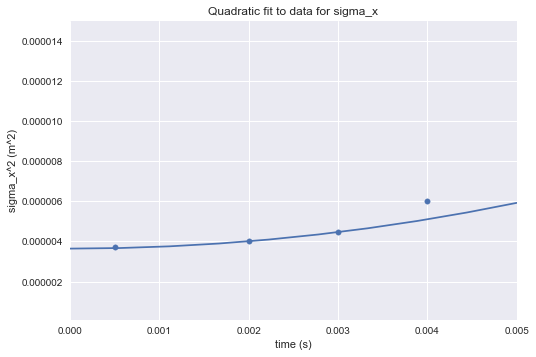

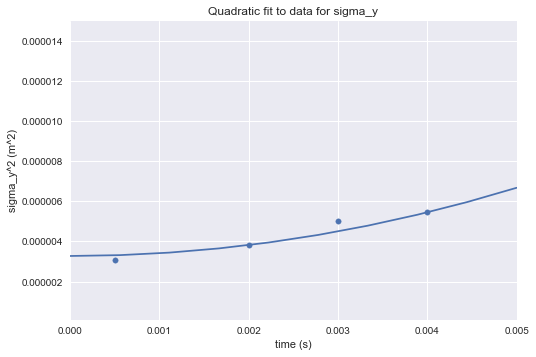

The fitted temepratures: T_x = 0.647146 mK, T_y = 0.965330 mK, T = 0.739423 mK


[0.00064714555426179923, 0.00096532954299613277, 0.00073942338344149059]

In [6]:
pm.find_MOT_temp (q, pixel_distance_ratio = 0.4*10**(-3), time_conversion_ratio = 10**(-3), max_power = 60*10**(-3), suppressMessages = False)

The temperature of $\approx 1$ mK is what we expect.

Note that the uncertainties' magnitude varies greatly for each sampler run.

### Temperature vs. power

Run the temp_vs_power function with the whole data set (different powers, different powers). The function returns a pandas dataframe which we then plot.

In [7]:
dataPowerTemp = pm.temp_vs_power(separated_data_files)

(0.0005, 0.008)

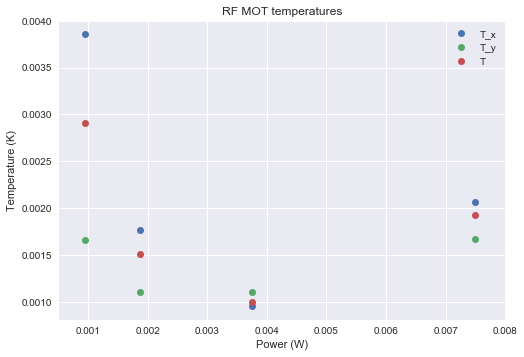

In [27]:
dataPowerTemp.plot(x = 'power', marker='o', linestyle='')
plt.ylabel('Temperature (K)')
plt.xlabel('Power (W)')
plt.title('RF MOT temperatures')
plt.gca().invert_xaxis()
plt.xlim([0.0005,0.008])

## Tests

If you are modifying the code, a number of tests can be run to ensure code integrity by typing

nosetests -v 

in the Command Prompt while being in the params_MOT folder. This will go through a series of unit tests which check that the various functions are still ouputting numbers correctly. The most important test is test_find_params_MOT. This serves a regression test which checks that the main function which uses MCMC to fit $\sigma_x,\sigma_y$ is still giving back reasonable results. It does this by generating artificial data via the gen_model_data function, reading this data, fitting it, and comparing the fitted values of $\sigma_x,\sigma_y$ to the original values used to generate the data. As MCMC is a stochastic process (and there is some random noise included in the generated data), the results of the fit will not be exactly the same every time the test is run, but the fitted values should be almost equal to the original parameter values up to 1 decimal place. If this test is passed, then it is very likely that the temperature fitting (which fits several fitted values of $\sigma_x,\sigma_y$ to a line) is also OK.